## Machine Learning II

### Cross-validation

Yesterday, we learned how to train a memory classifier on neural features. But we trained the classifier and tested its performance on the same dataset, which is very problematic in the machine-learning world. Why? 

If the purpose of machine learning methods is to make predictions on new data -- e.g. will this subject remember this word? -- then we want to test its performance on new data! Training a model involves finding a very particular set of weights on each feature, and those weights can end up being very specifically tuned to the training data. It'll do a great job predicting labels on data it already saw, but it will fail to predict labels for new and somewhat different data. 


<center>
<img src="https://cdn-images-1.medium.com/max/800/1*tBErXYVvTw2jSUYK7thU2A.png" width=500>
</center>


In ML parlance, we want our models to avoid **overfitting** the training data and to **generalize** to held-out datasets. Ensuring this generalizability by testing on held-out data is called **cross-validation**. Let's see how it's done!

<center>
<img src="https://cdn-images-1.medium.com/max/800/1*4G__SV580CxFj78o9yUXuQ.png" width=650>
</center>
    
<a href="https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6">Image source</a>


The basic idea to break up our dataset into **train/test splits**. There are many ways to do this: For instance, we could break up R1111M's events into quarters, by session, training on 3 sessions and testing on the fourth. You always want your training set to be bigger than your testing set.

See also here for a good tutorial on nested cross validation for parameter tuning: https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/

In [1]:
import numpy as np

# Re-load the data saved during Machine Learning I.
feats = np.load('R1111M_feature_matrix.npy')
Y = np.load('R1111M_recalled.npy')
sessions = np.load('R1111M_sessions.npy')

In [2]:
print(np.unique(sessions))

[0. 1. 2. 3.]


In [3]:
# Make our training data events from the first 3 sessions.
# Remember that the feature matrix is events X features in shape
training_data = feats[sessions<3, :]
training_Y = Y[sessions<3]

# Make our testing data from the last session.
testing_data = feats[sessions==3, :]
testing_Y = Y[sessions==3]

print('Train:'+str(training_data.shape))
print('Test:'+str(testing_data.shape))

Train:(780, 800)
Test:(240, 800)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Instantiate the classifier and fit to training data.
C_ = 7.2e-4
lr_classifier = LogisticRegression(C=C_, penalty='l2', class_weight='balanced', solver='liblinear')
lr_classifier.fit(training_data, training_Y)

LogisticRegression(C=0.00072, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
# Test the model on the held-out session.
recall_prob_array = lr_classifier.predict_proba(testing_data)[:,1]
auc = roc_auc_score(testing_Y, recall_prob_array)
print(auc)

0.6359652173913044


Pretty good, but not as good as our AUC from yesterday, when we trained and tested on the same dataset. Let's try all possible combinations of leave-one-session-out train/test splits, and compute the average AUC across all splits.

In [6]:
test_aucs = []
test_rocs = []

# Loop through all possible sessions as the testing set.
for test_sess in np.unique(sessions):
    
    # Make our train/test splits across sessions.
    training_data = feats[sessions!=test_sess, :]
    training_Y = Y[sessions!=test_sess]
    
    testing_data = feats[sessions==test_sess, :]
    testing_Y = Y[sessions==test_sess]
    
    # Fit the classfier to the training set.
    lr_classifier = LogisticRegression(C=C_, penalty='l2', class_weight='balanced', solver='liblinear')
    lr_classifier.fit(training_data, training_Y)
    
    # Compute the AUC for each testing set.
    recall_prob_array = lr_classifier.predict_proba(testing_data)[:,1]
    auc = roc_auc_score(testing_Y, recall_prob_array)
    test_aucs.append(auc)
    
    # Compute the ROC for each testing set.
    roc_curve_data = roc_curve(testing_Y, recall_prob_array)
    test_rocs.append(roc_curve_data)

In [7]:
print(test_aucs)
print(np.mean(test_aucs))

[0.7465521472392639, 0.7096072244587097, 0.7040151251306035, 0.6359652173913044]
0.6990349285549704


While these are all quite good AUCs, indiciating the classifier can distinguish good vs. bad memories well above chance, none of them are quite as good as our training-set AUC of 0.77 from yesterday. That's to be expected -- essentially, the classifier was overfit to the training data. 

Text(0, 0.5, 'TPR')

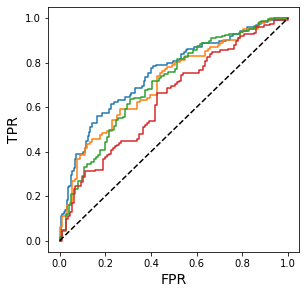

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the ROC curve for each held-out session.
plt.figure(figsize=(4.5, 4.5))

for roc_ in test_rocs:
    fpr = roc_[0]
    tpr = roc_[1]
    
    plt.plot(fpr, tpr)

# Make the plot pretty.
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)

Awesome! We've got a unique ROC curve for each held-out session. But how do we test the statistical significance of an AUC? What kind of predictability could we have achieved by chance? We could use a permutation test to answer this, but only if we have time!

In [9]:
# Note that k-fold cross validation can be implemented directly in sklearn.
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)

for train_index, test_index in kf.split([0, 1, 2, 3]):
    print(train_index)
    print(test_index)

[1 2 3]
[0]
[0 2 3]
[1]
[0 1 3]
[2]
[0 1 2]
[3]


**Exercise: Implement k-fold cross validation at the *item level* instead of session level. Does this work? How do the AUCs change? Why? <br>
Hint: Try playing around with the n_splits parameter in sklearn's KFold functionality.**

### Feature Selection

**Feature selection** an important part of designing effective machine learning models. What features are most important for making correct classifications? Are we asking our models to sift through many more feature than are necessary? How do we decide what the best features are? 

There is no "right" way to do feature selection. In fact, some of the best feature selection is done of the basis of your **pre-existing domain knowledge.** We know, for example, that spectral power in frequencies between 3 and 200 Hz are related to episodic memory, so we fed those into our algorithm instead of 1 Hz or 300 Hz activity. Other neuroscientists might have suggested an even smaller range of frequencies! Understanding the data you're working with can really help!

There are also algorithmic approaches to feature selection:

* A common approach to reducing the feature space is **principle components analysis**, or PCA. We don't have time to get into the details, but the big-picture idea is that PCA reduces a high-dimensional matrix to a much lower-dimensional form, by finding a set of orthogonal axes which best capture the variability in the data. 
* You can also select features based on the *univariate* correlation with your dependent variable. We already calculated univariate t-statistics a few days ago! A reasonable approach would be to find the top N features, ranked by their t-statistics, and only select those to enter your feature matrix. 
* *Always* make sure that any feature-selection process you choose is calculated without mixing values between the training and the testing set. Find the best features using the training set, and select those same features in the test set -- no peeking into the test set before you run your model!

#### PCA on the feature matrix

Text(0, 0.5, 'PC2')

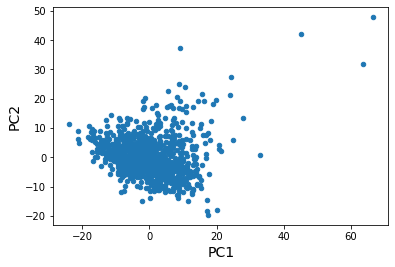

In [10]:
from sklearn.decomposition import PCA

# Instantiate our PCA class.
pca = PCA(n_components=5)

# Reduce the feature matrix to 5 dimensions.
feats_red = pca.fit_transform(feats)

# Plot the first two principle components.
plt.figure()
plt.scatter(feats_red[:, 0], feats_red[:, 1], s=20)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)

**Exercise: Re-run logistic regression using the 5 PCA-reduced features. How does model performance compare to the original feature matrix?**

### Ranking by univariate statistics

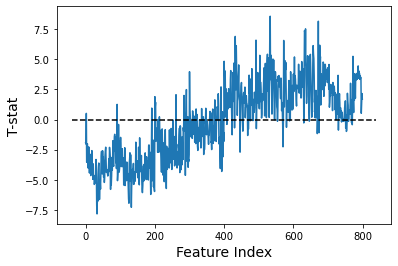

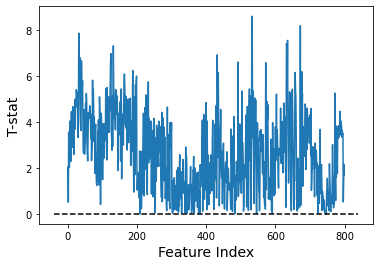

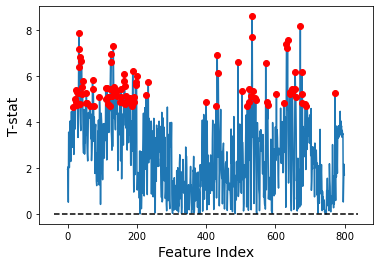

In [12]:
# Basic idea is to find the univariate features that have the best correlation
# with memory state, pick the top N, and use those for classification.

# Run 2-sample t-test between remembered and not-remembered items in the feature matrix.
from scipy.stats import ttest_ind
t, p = ttest_ind(feats[Y==1, :], feats[Y==0, :], axis=0, equal_var=False)

# Plot results.
plt.figure()
ax = plt.subplot(111)
plt.plot(t);
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='k', linestyles='--')
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('T-stat', fontsize=14);

# Since we're interested in the most memory-relevant variables,
# taking the absolute value of the t-stats is helpful.
plt.figure()
ax = plt.subplot(111)
plt.plot(np.abs(t));
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='k', linestyles='--')
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('T-stat', fontsize=14);

# Rank and select the top 100 most memory-relevant features.
rank_idx = np.argsort(np.abs(t))
picks = rank_idx[-100:]

plt.figure()
ax = plt.subplot(111)
plt.plot(np.abs(t));
plt.plot(picks, np.abs(t)[picks], 'o', color='red')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='k', linestyles='--')
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('T-stat', fontsize=14);

**Exercise: Feature selection should take place in a cross-validated manner. That is, features should be selected on the basis of training data, and then applied to testing data. Re-write the session-level cross validation with univariate-based feature selection. What happens to classifier performance?**